# Dog Breed Classifier Project

## 5. Deploying the model to Google AI Platform

We assume that the following steps have been carried out:
- Created a project on Google Cloud Platform, and a service account with the role 'ML Engine Developer'
- Saved the private key linked to that service account as a JSON file to the hard drive
- Set an OS environment variable named 'GOOGLE_APPLICATION_CREDENTIALS' with the path to the JSON file as a value
- Saved the trained model in the TensorFlow format (model.save('Filename', save_format='tf'))
- Uploaded the model (the entire folder) to a bucket on Google Cloud Platform > Storage
- Created a model on Google Cloud Platform > Google AI Platform > Models, and a version of that model, linking to the bucket containing the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import os.path
import math
import pickle
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
# Check whether Google credentials are saved as an OS environment variable
print('Path to Google credentials : {}'.format(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')))

In [3]:
# Name of project and model on GCP
PROJECT_NAME = 'dog-breed-classifier-267206'
MODEL_NAME = 'dogbreedclassifier'
VERSION = 'v1'

In [35]:
# Reduce image size to meet GCP free-tier API request size limit
IMG_WIDTH, IMG_HEIGHT = 140, 140

In [36]:
# Function to send JSON data for prediction
import googleapiclient.discovery

def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [37]:
# Import labels of pictures
labels = pickle.load(open('./labels.pickle', 'rb'))

In [38]:
# Function to randomly select, pre-process pictures from a PATH and get predictions on those pictures
def pick_pictures(PATH):
    fig=plt.figure(figsize=(20, 12))
    
    # Browse files in the PATH directory
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(PATH):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    
    ax = []
    
    # Randomly pick a certain number of pictures from the list
    files = random.sample(range(len(listOfFiles)), 10)
    
    for i in range(columns*rows):
        # Transform each image into a Tensor
        img = image.load_img(listOfFiles[files[i]], target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        
        # Get predictions from the model (the name of the last layer needs to be specified)
        instances = img_preprocessed.tolist()
        prediction = predict_json(PROJECT_NAME, MODEL_NAME, instances, version=VERSION)
        prediction = np.array(prediction[0]['dense_5']) # 'dense_5' is the name of the classification layer. Might change if we recompile the model.        

        # Retrieve the label and probability for the top two guesses
        first_index = prediction.argsort()[-2:][1]
        second_index = prediction.argsort()[-2:][0]
       
        # Plot the results in an ordered fashion
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("Probably a {}".format(labels[first_index].split('.')[1]) +
                         "\n({:.2f} % chance)".format(prediction[first_index]*100) +
                         "\n\nPossibly a {}".format(labels[second_index].split('.')[1]) +
                         "\n({:.2f} % chance)".format(prediction[second_index]*100) +
                         "\n\nGround truth: {}".format(listOfFiles[files[i]].split("/")[2].split(".")[1].split("\\")[0])
                         )

        plt.axis('off')
        plt.imshow(img)

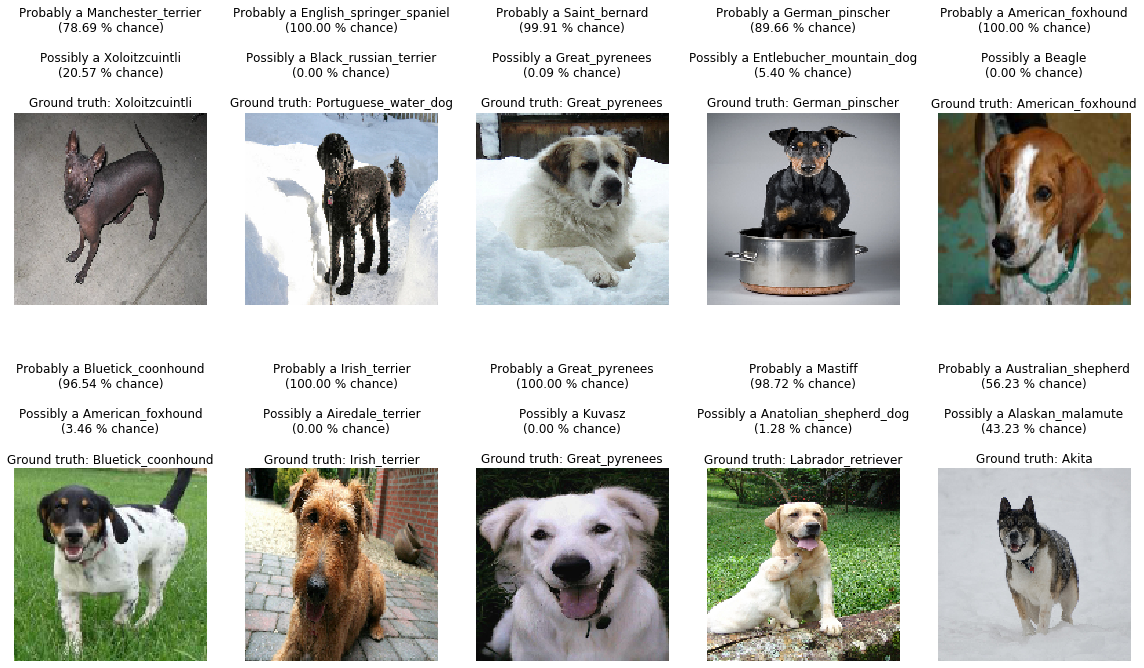

In [39]:
PATH = 'images/test/'

columns = 5
rows = 2

pick_pictures(PATH)